## Import Libraries

In [1]:
import cv2 
import pickle
import matplotlib.pyplot as plt
import hashlib
import ipywidgets as widgets
from IPython.display import display

### Images function

In [2]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints
imagesBW = []
imagesHashes = {}


def imageResizeTrain(image):
    maxD = 1024
    try:
        height,width = image.shape
    except:
        height,width,_ = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def getFileHash(imagePath):
    BUF_SIZE = 65536
    
    sha1 = hashlib.sha1()

    with open(imagePath, "rb") as f:
        while True:
            data = f.read(BUF_SIZE)
            if not data:
                break
            sha1.update(data)
    return f"{sha1.hexdigest()}"

### CV2 configuration

In [3]:
# Using opencv's sift implementation here
sift = cv2.SIFT_create()
def computeSIFT(image):
    return sift.detectAndCompute(image, None)

bf = cv2.BFMatcher()

### Calculating SIFT and caching

In [8]:
def computeAndCacheSIFT(image_path):
    imageHashStr = getFileHash(image_path)
    image = imageResizeTrain(cv2.imread(image_path,0))
    
    if imageHashStr not in imagesHashes:
        keypointTemp, descriptorTemp = computeSIFT(image)
        imagesHashes[imageHashStr] = {
            "keypoint": keypointTemp,
            "descriptor": descriptorTemp
        }
    return imageHashStr

def plotKeypoints(image_path):
    image = imageResizeTrain(cv2.imread(image_path, 0))
    imageHashStr = computeAndCacheSIFT(image_path)
    keypoints = imagesHashes[imageHashStr]["keypoint"]
    
    plot_data = cv2.drawKeypoints(image, keypoints, None, flags=2)
    plt.imshow(plot_data),plt.show()

def getPlot(image1, image2, keypoint1, keypoint2, matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        [255,0,0],
        flags=2
    )
    return matchPlot


def calculateMatches(des1, des2, distance=0.7):
    matches = bf.knnMatch(des1, des2, k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < distance*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < distance*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

def getPlotFor(file1, file2, keypoint1, keypoint2, matches):
    image1 = imageResizeTest(cv2.imread(file1))
    image2 = imageResizeTest(cv2.imread(file2))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1, keypoint2))

### The following is the main function to generate the keypoints and descriptors<br>
When using SIFT, this takes a lot of time to compute.<br>
Thus, it is suggested, you store the values once computed<br>
(Code for storing is written below)

In [10]:
def calculateImageSimilarity(image_1_path, image_2_path, distance=0.7):
    image1HashStr = computeAndCacheSIFT(image_1_path)
    image2HashStr = computeAndCacheSIFT(image_2_path)
    
    keypoint1 = imagesHashes[image1HashStr]["keypoint"]
    descriptor1 = imagesHashes[image1HashStr]["descriptor"]
    
    keypoint2 = imagesHashes[image2HashStr]["keypoint"]
    descriptor2 = imagesHashes[image2HashStr]["descriptor"]
    
    matches = calculateMatches(descriptor1, descriptor2, distance)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    
    plot = getPlotFor(image_1_path, image_2_path, keypoint1,keypoint2,matches)
    print(f"Score: {score}")
    plt.imshow(plot),plt.show()

### Test

Score: 9.704830053667262


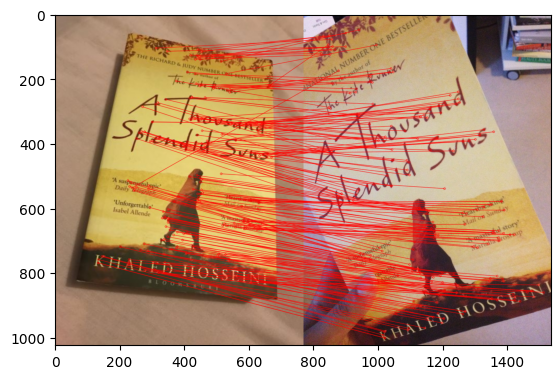

In [13]:
# A score greater than 10 means very good
calculateImageSimilarity("./data/images/book1.jpeg", "./data/images/book2.jpeg")

### Interactive compare between two images

In [14]:
distance = widgets.FloatSlider(description="Distance", value=0.7, min=0, max=2, step=0.05)
image_1 = widgets.FileUpload(description="Image 1", accept="image/*", multiple=False)
image_2 = widgets.FileUpload(description="Image 2", accept="image/*", multiple=False)

SHOW_KEYPOINTS = True

def calculateImagesDifference(distance, image_1, image_2):
    if not image_1 or not image_2:
        print("Please upload images")
        return
    IMAGE_1 = "/tmp/image-random1.png"
    IMAGE_2 = "/tmp/image-random2.png"
    image_1 = image_1[0]
    image_2 = image_2[0]
    with open(IMAGE_1, "wb") as f:
        f.write(image_1["content"])
    with open(IMAGE_2, "wb") as f:
        f.write(image_2["content"])
    print(f"Using distance={distance}")
    calculateImageSimilarity(IMAGE_1, IMAGE_2, distance)

    if SHOW_KEYPOINTS:
        # Plot keypoints first
        plotKeypoints(IMAGE_1)
        plotKeypoints(IMAGE_2)
        
out = widgets.interactive_output(calculateImagesDifference, {'distance': distance, 'image_1': image_1, 'image_2': image_2})

display(image_1)
display(image_2)
display(distance)
display(out)

FileUpload(value=(), accept='image/*', description='Image 1')

FileUpload(value=(), accept='image/*', description='Image 2')

FloatSlider(value=0.7, description='Distance', max=2.0, step=0.05)

Output()